In [1]:
import pandas as pd
import joblib
import os
import time

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from xgboost import XGBClassifier

import seaborn as sns
import matplotlib.pyplot as plt

# --- Configuration ---
INPUT_FILE = 'final_cleaned_dataset.csv'
OUTPUT_DIR = 'models'

# Create the output directory if it doesn't exist
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

print("Setup complete.")

Setup complete.


In [2]:
print("--- [Step 1/4] Loading and Preparing Data ---")

# Load the master dataset
df = pd.read_csv(INPUT_FILE)

# Define columns to be excluded from training
identifier_cols = ['src_ip', 'src_port', 'dst_ip', 'timestamp', 'flow_id']
feature_cols = [col for col in df.columns if col not in ['label'] + identifier_cols]

X = df[feature_cols]
y = df['label']

# Encode text labels into numbers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(f"-> Data loaded and split into training ({X_train.shape}) and testing ({X_test.shape}) sets.")

--- [Step 1/4] Loading and Preparing Data ---
-> Data loaded and split into training ((3634734, 78)) and testing ((908684, 78)) sets.


In [3]:
print("--- [Step 2/4] Training XGBoost Model ---")

# Initialize the XGBoost classifier with good default settings
xgb_model = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='mlogloss')

# Train the model and time the process
start_time = time.time()
xgb_model.fit(X_train, y_train)
end_time = time.time()

print(f"-> Training completed in {((end_time - start_time) / 60):.2f} minutes.")

--- [Step 2/4] Training XGBoost Model ---
-> Training completed in 3.61 minutes.


--- [Step 3/4] Evaluating Model Performance ---

-> Model Accuracy: 95.32%

--- Classification Report ---
               precision    recall  f1-score   support

       benign       0.95      0.99      0.97    453242
          bot       1.00      1.00      1.00     57238
   bruteforce       0.87      0.96      0.91     76358
     dos_ddos       0.99      0.96      0.97    287259
 infiltration       0.73      0.28      0.40     34387
sql_injection       0.94      1.00      0.97       200

     accuracy                           0.95    908684
    macro avg       0.91      0.87      0.87    908684
 weighted avg       0.95      0.95      0.95    908684


--- Confusion Matrix ---


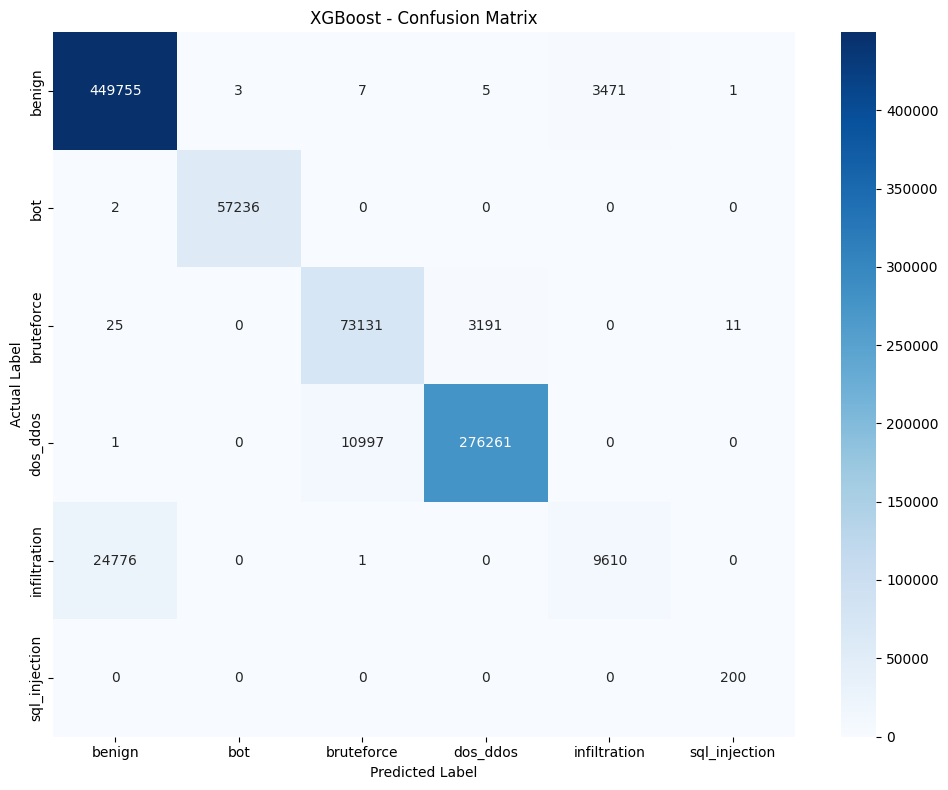

In [4]:
print("--- [Step 3/4] Evaluating Model Performance ---")

# Make predictions on the test set
predictions = xgb_model.predict(X_test)

# Print the main classification metrics
accuracy = accuracy_score(y_test, predictions) * 100
print(f"\n-> Model Accuracy: {accuracy:.2f}%")
print("\n--- Classification Report ---")
print(classification_report(y_test, predictions, target_names=label_encoder.classes_))

# Visualize the confusion matrix
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('XGBoost - Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

In [5]:
print("--- [Step 4/4] Saving Final Model and Encoder ---")

# Save the trained XGBoost model
model_filename = os.path.join(OUTPUT_DIR, 'xgb_model.joblib')
joblib.dump(xgb_model, model_filename)
print(f"-> Model saved successfully to: {model_filename}")

# Save the label encoder
encoder_filename = os.path.join(OUTPUT_DIR, 'label_encoder.joblib')
joblib.dump(label_encoder, encoder_filename)
print(f"-> Label encoder saved successfully to: {encoder_filename}")

print("\n✅ All assets exported successfully!")

--- [Step 4/4] Saving Final Model and Encoder ---
-> Model saved successfully to: models\xgb_model.joblib
-> Label encoder saved successfully to: models\label_encoder.joblib

✅ All assets exported successfully!


In [6]:
print("--- Creating a subsample for efficient hyperparameter tuning ---")

# We'll use 20% of the training data for the search to ensure it fits in memory.
sample_fraction = 0.2

# Create a smaller, stratified sample to maintain the class distribution
X_train_sample, _, y_train_sample, _ = train_test_split(
    X_train,
    y_train,
    train_size=sample_fraction,
    stratify=y_train,
    random_state=42
)

print(f"Original training data shape: {X_train.shape}")
print(f"New subsample shape for tuning: {X_train_sample.shape}")

--- Creating a subsample for efficient hyperparameter tuning ---
Original training data shape: (3634734, 78)
New subsample shape for tuning: (726946, 78)


In [7]:
from sklearn.model_selection import RandomizedSearchCV

print("--- Starting Hyperparameter Tuning for XGBoost (on a subsample) ---")

# Define the range of parameters to search through
param_grid = {
    'n_estimators': [100, 200, 300, 400],
    'max_depth': [5, 7, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.7, 0.8, 0.9, 1.0]
}

# Set up RandomizedSearchCV
xgb_for_tuning = XGBClassifier(random_state=42, n_jobs=-1, eval_metric='mlogloss')
random_search = RandomizedSearchCV(
    estimator=xgb_for_tuning,
    param_distributions=param_grid,
    n_iter=20, # Test 20 combinations
    cv=3,      # Use 3-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Run the search on the SAMPLE data
print("\n--> Starting the random search... This may take a long time.")
start_time = time.time()
random_search.fit(X_train_sample, y_train_sample)
end_time = time.time()
print(f"--> Random search completed in {((end_time - start_time) / 60):.2f} minutes.")

# Get the best parameters
best_params = random_search.best_params_
print("\n--- Best Parameters Found ---")
print(best_params)

--- Starting Hyperparameter Tuning for XGBoost (on a subsample) ---

--> Starting the random search... This may take a long time.
Fitting 3 folds for each of 20 candidates, totalling 60 fits
--> Random search completed in 107.53 minutes.

--- Best Parameters Found ---
{'subsample': 0.8, 'n_estimators': 200, 'max_depth': 10, 'learning_rate': 0.05, 'colsample_bytree': 0.8}


In [8]:
print("--- Training the final, tuned XGBoost model on the FULL dataset ---")

# Create a new model using the best parameters
final_tuned_xgb = XGBClassifier(**best_params, random_state=42, n_jobs=-1, eval_metric='mlogloss')

# Train it on the ENTIRE training set
start_time = time.time()
final_tuned_xgb.fit(X_train, y_train)
end_time = time.time()
print(f"--> Final model training completed in {((end_time - start_time) / 60):.2f} minutes.")

# Evaluate the final, tuned model
predictions = final_tuned_xgb.predict(X_test)
accuracy = accuracy_score(y_test, predictions) * 100

print(f"\n-> FINAL Tuned XGBoost Accuracy: {accuracy:.2f}%")
print("\n--- FINAL Tuned XGBoost Classification Report ---")
print(classification_report(y_test, predictions, target_names=label_encoder.classes_))

# Save the final tuned model
print("\n--- Saving Final Tuned Model ---")
final_model_filename = os.path.join(OUTPUT_DIR, 'final_tuned_xgb_model.joblib')
joblib.dump(final_tuned_xgb, final_model_filename)
print(f"-> Final tuned model saved to: {final_model_filename}")

--- Training the final, tuned XGBoost model on the FULL dataset ---
--> Final model training completed in 8.54 minutes.

-> FINAL Tuned XGBoost Accuracy: 95.34%

--- FINAL Tuned XGBoost Classification Report ---
               precision    recall  f1-score   support

       benign       0.95      0.99      0.97    453242
          bot       1.00      1.00      1.00     57238
   bruteforce       0.87      0.96      0.91     76358
     dos_ddos       0.99      0.96      0.97    287259
 infiltration       0.74      0.28      0.41     34387
sql_injection       0.95      1.00      0.98       200

     accuracy                           0.95    908684
    macro avg       0.92      0.87      0.87    908684
 weighted avg       0.95      0.95      0.95    908684


--- Saving Final Tuned Model ---
-> Final tuned model saved to: models\final_tuned_xgb_model.joblib
